In [ ]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, add, AveragePooling2D
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras import optimizers
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
def normalize(x):
  mean = np.mean(x, axis = (0, 1, 2, 3))
  std = np.std(x, axis = (0, 1, 2, 3))
  print(mean)
  print(std)
  x = (x - mean) / std
  return x

x_train = normalize(x_train)
x_test = normalize(x_test)

121.93584
68.38902
122.241035
68.63058


In [ ]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)
y_val1 = keras.utils.to_categorical(y_val, 100)

In [ ]:
# Ref: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/
# Ref: https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624
def residual_layer(layer_in, filters):
	inp = layer_in

	if layer_in.shape[-1] != filters:
		inp = Conv2D(filters = filters, kernel_size = (1,1), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_in)
	
	conv1 = Conv2D(filters = filters, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_in)
	conv1 = BatchNormalization()(conv1)

	conv2 = Conv2D(filters = filters, kernel_size = (3,3), padding = 'same', activation = 'linear', kernel_initializer = 'he_normal')(conv1)
	conv2 = BatchNormalization()(conv2)

	layer_out = add([conv2, inp])
	layer_out = Activation('relu')(layer_out)
  
	return layer_out

input = Input(shape = (32, 32, 3))
conv = Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(input)
conv = BatchNormalization()(conv)

pool1 = MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(conv)

filters = 64
inp = pool1

for i in [2, 2, 2, 2]:
  for j in range(i):
    out = residual_layer(inp, filters)
    inp = out
  filters *= 2

pool2 = AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(out)
flatten = Flatten()(pool2)
dense = Dense(units = 100, kernel_initializer = "he_normal", activation = "softmax")(flatten)

model = Model(inputs = input, outputs = dense)


In [ ]:
opt = optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

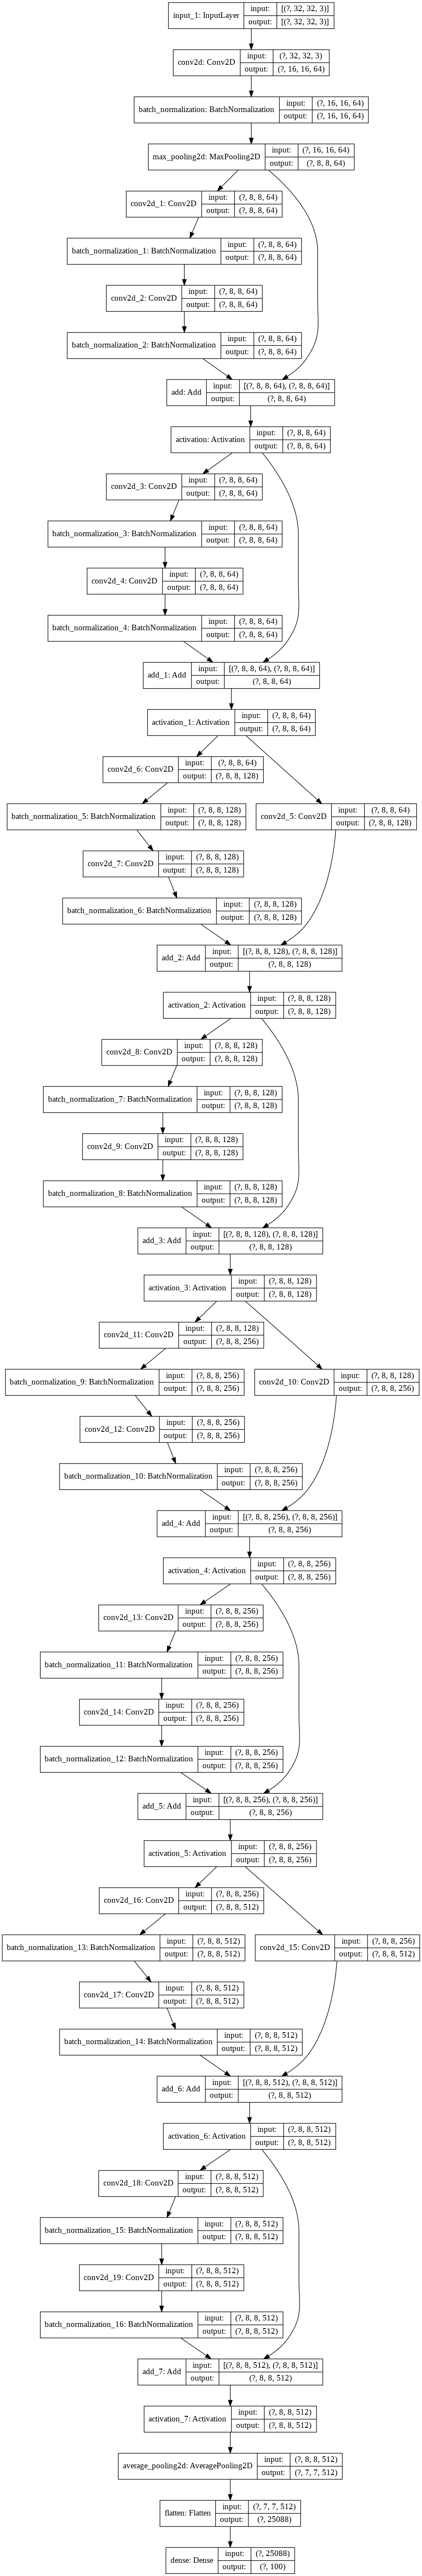

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes = True, to_file = 'ResNet18.png')

In [ ]:
datagen = ImageDataGenerator(
            rotation_range = 15,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            horizontal_flip = True)
datagen.fit(x_train)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 128
checkpoint = ModelCheckpoint("RESNET18_ADAM_BatchNormalization.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 20, verbose = 1, mode = 'auto')
hist = model.fit_generator(steps_per_epoch = x_train.shape[0] // batch_size, generator = datagen.flow(x_train, y_train1, batch_size = batch_size), validation_data = (x_val, y_val1), validation_steps = 10,epochs = 200,callbacks = [checkpoint, early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
390/390 [==============================] - ETA: 0s - loss: 5.2238 - accuracy: 0.1036WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0058s vs `on_test_batch_end` time: 0.0735s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.17000, saving model to RESNET18_ADAM_NoRegularization.h5
390/390 [==============================] - 36s 92ms/step - loss: 5.2238 - accuracy: 0.1036 - val_loss: 3.5288 - val_accuracy: 0.1700
Epoch 2/200
390/390 [==============================] - ETA: 0s - loss: 3.0625 - accuracy: 0.2489
Epoch 00002: val_accuracy improved from 0.17000 to 0.26420, saving model to RESNET18_ADAM_NoRegularization.h5
390/390 [==============================] - 33s 86ms/step - loss: 3.0625 - accuracy: 0.2489 - val_loss: 3.0495 - val_accuracy: 0.2642
Epoch 3/200
390/390 [==============================] - ETA: 0s - loss: 2.7

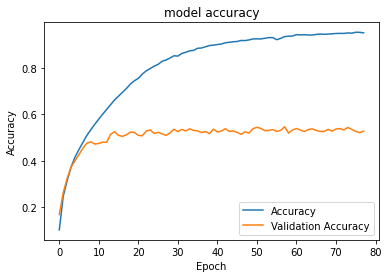

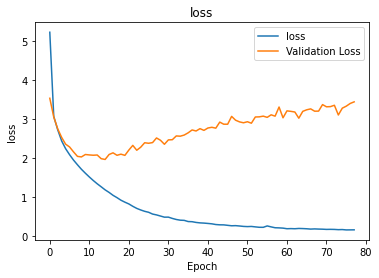

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.savefig('resnet_adam_bn_acc.png')
plt.show()

plt.figure(2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("loss")
plt.ylabel("loss")        
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.savefig('resnet_adam_bn_loss.png')
plt.show()


### Evaluation of Model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.datasets import cifar100
import numpy as np
import keras

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

def normalize(x):
    mean = np.mean(x, axis = (0, 1, 2, 3))
    std = np.std(x, axis = (0, 1, 2, 3))
    print(mean)
    print(std)
    x = (x - mean) / std
    return x

x_train = normalize(x_train)
x_test = normalize(x_test)

y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)

169009152/169001437 [==============================] - 4s 0us/step
121.93584
68.38902
122.241035
68.63058


In [ ]:
from keras.models import load_model
import os

path = os.path.join(os.path.dirname(os.getcwd()), "weights\ResNet18_ADAM_BatchNormalization.h5")
# path = '/content/drive/My Drive/weights/ResNet18_ADAM_BatchNormalization.h5'
print(path)
model1 = load_model(path)

/content/drive/My Drive/weights/ResNet18_ADAM_BatchNormalization.h5


In [ ]:
_, accuracy = model1.evaluate(x_test, y_test1)

313/313 [==============================] - 3s 10ms/step - loss: 2.9669 - accuracy: 0.5506


In [ ]:
pred = model1.predict(x_test)
pred = [np.argmax(x) for x in pred]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(pred, y_test)
cr = classification_report(pred, y_test)

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.80      0.79        99
           1       0.66      0.64      0.65       103
           2       0.45      0.42      0.43       107
           3       0.33      0.45      0.38        74
           4       0.40      0.35      0.37       114
           5       0.45      0.53      0.49        85
           6       0.63      0.53      0.58       118
           7       0.50      0.69      0.58        72
           8       0.71      0.56      0.63       127
           9       0.60      0.73      0.66        82
          10       0.34      0.33      0.33       104
          11       0.45      0.38      0.41       117
          12       0.64      0.59      0.61       109
          13       0.50      0.56      0.53        90
          14       0.56      0.44      0.49       127
          15       0.44      0.55      0.49        80
          16       0.58      0.64      0.61        91
          17       0.70    

In [ ]:
np.set_printoptions(threshold = np.inf)
cm

array([[79,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  1],
       [ 0, 66,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  2,  1,
         0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  1,  0,  0,  1,  0,  0,
         2,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  1,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0,  1,  3,  0,
         1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  2,  1,  2,  0,  0,
         0,  1,  0,  0],
       [ 0,  1, 45,  0,  0,  0,  0,  0,  0,  0,  1, 11,  0,  0,  0,  1,
         1,  0